In [1]:
import os
import sys

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy.table import Table
from astropy.io import fits

%matplotlib inline
from matplotlib import style, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
table.pprint.conf.max_lines = 30

In [3]:
def leg_tree(leg, al=1):
    for c in leg.get_children():
        if hasattr(c, 'set_alpha'):
            c.set_alpha(al)
        leg_tree(c)

# Unstacked

In [4]:
tab = Table.read('vdev_obj1_jegpeek.fits.gz')
tab

mo_raMean,mo_decMean,mo_gMeanPSFMag,mo_gMeanPSFMagErr,mo_rMeanKronMag,mo_iMeanApMag,mo_yMeanPSFMag,mo_yMeanPSFMagErr,mo_gMeanKronMag,mo_rMeanApMag,mo_zMeanPSFMag,mo_zMeanPSFMagErr,mo_gMeanApMag,mo_yMeanKronMag,mo_iMeanPSFMag,mo_iMeanPSFMagErr,mo_ng,mo_zMeanKronMag,mo_yMeanApMag,mo_raStack,mo_nr,mo_decStack,mo_ni,mo_rMeanPSFMag,mo_nz,mo_rMeanPSFMagErr,mo_ny,mo_iMeanKronMag,mo_zMeanApMag
float64,float64,float32,float64,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float64,int16,float32,float32,float64,int16,float64,int16,float32,int16,float64,int16,float32,float32
17.97671162,24.06687209,21.1554,0.027163,20.376,20.2568,20.0688,0.097788,20.8386,20.3311,20.396,0.032778,20.8137,19.639,20.7722,0.022039,15,19.9235,19.6436,17.9767191,13,24.06687756,18,20.7796,10,0.023343,4,20.2359,19.8862
17.99636956,24.07523889,19.3055,0.006491,18.7801,18.388,18.1839,0.012593,19.4219,18.6827,18.2921,0.006211,19.3204,18.2688,18.3947,0.00369,15,18.3553,18.1624,17.99638078,15,24.07522917,14,18.6795,11,0.004657,15,18.4731,18.2715
17.99466764,24.08526267,22.0515,0.129559,21.4801,20.9887,-999.0,-999.0,22.2322,21.4608,20.7608,0.124106,22.2242,-999.0,21.2391,0.055179,5,20.7583,-999.0,17.99469452,5,24.08525488,8,21.6675,3,0.067788,0,20.8416,20.6934
17.01212867,24.1140728,22.2929,0.130649,21.8146,20.7945,19.6711,0.049503,22.2318,21.7332,20.5552,0.037754,22.2811,19.5183,20.8729,0.024306,2,20.6663,19.7475,17.0121339,4,24.11409598,16,21.7289,12,0.082328,10,20.8112,20.5721
18.59823289,24.11547676,21.2161,0.05055,20.0922,19.3841,18.8582,0.020933,21.2343,19.9896,19.0608,0.009818,21.462,18.9429,19.3768,0.00771,7,19.1098,18.8581,18.59825004,12,24.11546757,16,19.9852,15,0.012238,16,19.4935,19.0405
18.31348188,24.1169367,21.3321,0.048597,20.0458,19.5824,19.539,0.055447,20.9246,19.9947,19.8661,0.021496,20.888,19.1412,20.0868,0.012858,10,19.3142,19.5788,18.31349355,17,24.11693051,18,20.454,11,0.015525,9,19.5992,19.3098
18.4205914,24.12377574,20.8008,0.051182,19.9843,19.1389,18.563,0.018656,20.3032,19.8693,18.7546,0.008354,20.5375,18.6703,19.12,0.005991,6,18.8493,18.573,18.42058984,15,24.12377788,16,19.8871,17,0.011133,16,19.2322,18.7647
18.53253245,24.11959535,21.8236,0.0881,20.8459,20.455,20.4487,0.166965,21.2308,20.7997,20.7055,0.053927,21.4891,20.1483,20.9951,0.031957,4,20.2589,20.1754,18.53252206,14,24.11959479,13,21.3493,8,0.033315,1,20.4576,20.1755
16.97329856,24.12853303,21.9554,0.074913,20.6156,19.8696,19.6441,0.052861,21.5971,20.5598,19.969,0.023082,21.5356,19.3191,20.3888,0.020616,5,19.5943,19.3164,16.97329209,6,24.12855106,12,20.9552,15,0.034035,8,19.9036,19.544


In [5]:
bands = 'griy'
btoc = {'g': 'g', 'r':'r', 'y':'k','i':'m'}

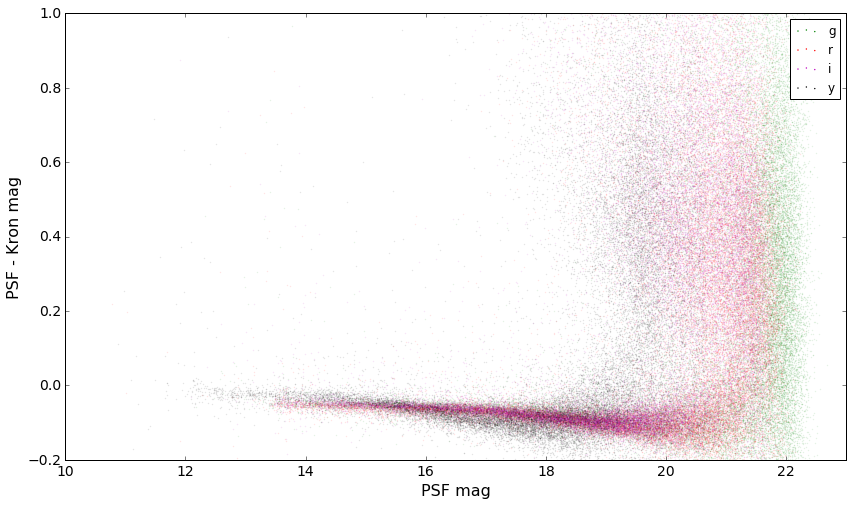

In [6]:
psfmkron = {}
for band in bands:
    psfnm = 'mo_{}MeanPSFMag'.format(band)
    kronnm = 'mo_{}MeanKronMag'.format(band)
    apnm = 'mo_{}MeanApMag'.format(band)
    
    psfmkron[band] = tab[psfnm] - tab[kronnm]
    
    plt.scatter(tab[psfnm], psfmkron[band], c=btoc[band], label=band, lw=0, alpha=.1,s=2)
    
leg_tree(plt.legend(loc=0))
plt.xlim(10, 23)
plt.ylim(-.2, 1)
plt.xlabel('PSF mag')
plt.ylabel('PSF - Kron mag')

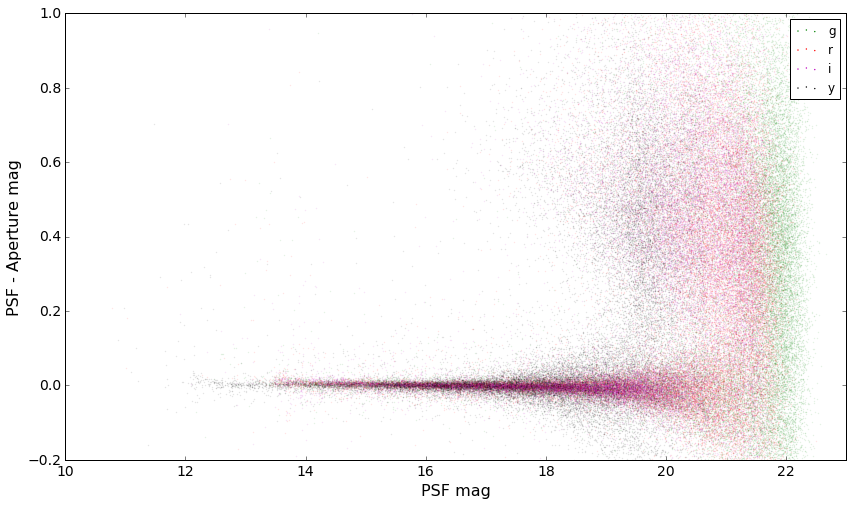

In [7]:
psfmap = {}
for band in bands:
    psfnm = 'mo_{}MeanPSFMag'.format(band)
    kronnm = 'mo_{}MeanKronMag'.format(band)
    apnm = 'mo_{}MeanApMag'.format(band)
    
    psfmap[band] = tab[psfnm] - tab[apnm]
    
    plt.scatter(tab[psfnm], psfmap[band], c=btoc[band], label=band, lw=0, alpha=.1,s=2)
    
leg_tree(plt.legend(loc=0))

plt.xlim(10, 23)
plt.ylim(-.2, 1)
plt.xlabel('PSF mag')
plt.ylabel('PSF - Aperture mag')

# subselect and  format for http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx

## Aperture 

In [16]:
magtype = 'ap'
psfmmag = psfmap

subtab = tab['mo_raMean', 'mo_decMean']
subtab['mo_raMean'].name = 'ra'
subtab['mo_decMean'].name = 'dec'

galmsk = np.zeros(len(subtab), dtype=bool)
for band in bands:
    subtab['psfm{}_{}'.format(magtype, band)] = psfmmag[band]
    galmsk = galmsk | (psfmmag[band] > .2)

name = [(str('gal' if b else 'star') +'_' + magtype + str(i)) for i,b in enumerate(galmsk)]
subtab.add_column(table.Column(name='name', data=name), 0)

subtabgal = subtab[galmsk]
subtabstar = subtab[~galmsk]

In [17]:
sample = np.random.permutation(len(subtabstar))[:25]
subtabstar['name', 'ra', 'dec'][sample].write(None, format='ascii')
subtabstar[sample]

name ra dec
star_ap14983 17.64322476 25.20051971
star_ap18622 17.2255653 25.15444162
star_ap24258 17.54016071 25.54886998
star_ap8655 18.40752046 24.60662732
star_ap13288 18.61910382 24.85085423
star_ap12697 17.40082096 24.87345414
star_ap4267 17.59278439 24.34810223
star_ap23234 18.3679834 25.39003901
star_ap8381 17.97862665 24.59287295
star_ap23938 18.04878215 25.39240484
star_ap28301 17.12162395 25.79205932
star_ap5391 17.4725864 24.40223662
star_ap9796 16.80429301 24.68688661
star_ap18014 18.62360824 25.55698727
star_ap1763 17.59112662 24.16094641
star_ap19096 18.53811675 25.45533222
star_ap13350 17.4394574 25.00129458
star_ap4781 17.18579704 24.36229175
star_ap17222 16.94143912 25.31885682
star_ap18090 17.61414963 25.35272903
star_ap25273 17.01303414 25.84312192
star_ap12185 18.48956288 24.79759302
star_ap16115 16.66926845 25.34464302
star_ap808 17.61526666 24.07599427
star_ap3734 17.06897995 24.3048258


name,ra,dec,psfmap_g,psfmap_r,psfmap_i,psfmap_y
str12,float64,float64,float32,float32,float32,float32
star_ap14983,17.64322476,25.20051971,-0.0256004,-0.00510025,0.0100002,-0.00220013
star_ap18622,17.2255653,25.15444162,0.0116005,0.00580025,0.0135002,0.00180054
star_ap24258,17.54016071,25.54886998,0.0053997,0.0102997,0.00540066,0.00419998
star_ap8655,18.40752046,24.60662732,0.0636997,0.0611,0.0195007,0.0382996
star_ap13288,18.61910382,24.85085423,0.0123005,-0.1472,-0.0142002,-0.00449944
star_ap12697,17.40082096,24.87345414,0.0855999,0.136299,0.0452003,0.0
star_ap4267,17.59278439,24.34810223,-0.578199,0.0242004,-0.0634003,-0.0240002
star_ap23234,18.3679834,25.39003901,-0.0279007,-0.00469971,0.0298004,0.0247002
star_ap8381,17.97862665,24.59287295,-0.00110054,-0.0166016,0.00670052,-0.0137005


In [18]:
sample = np.random.permutation(len(subtabgal))[:25]
subtabgal['name', 'ra', 'dec'][sample].write(None, format='ascii')
subtabgal[sample]

name ra dec
gal_ap16445 18.32793032 25.27684641
gal_ap12307 17.88992866 24.92455451
gal_ap24549 18.32762417 25.85226124
gal_ap17649 16.85010804 25.22718064
gal_ap8119 16.83948669 24.60228164
gal_ap21843 18.33793653 25.52119422
gal_ap16222 17.14978347 25.31484972
gal_ap18115 18.20651998 25.24629542
gal_ap4504 18.43879961 24.33564324
gal_ap21193 17.10492692 25.56323168
gal_ap20310 17.10440963 25.36777849
gal_ap8309 17.67713935 24.62382218
gal_ap6389 18.31617963 24.47722205
gal_ap3021 16.69316856 24.25658946
gal_ap17173 16.91993052 25.35231363
gal_ap764 16.91885521 24.07851595
gal_ap25832 18.43569995 26.00880541
gal_ap7469 18.06822507 24.56304645
gal_ap20632 17.4579838 25.04394536
gal_ap16039 16.87891695 25.19795212
gal_ap10507 16.98267161 24.72524969
gal_ap19686 17.49190815 25.3259053
gal_ap8750 16.97132994 24.61694617
gal_ap21869 16.74671703 25.38795824
gal_ap17566 17.26809414 25.22123408


name,ra,dec,psfmap_g,psfmap_r,psfmap_i,psfmap_y
str12,float64,float64,float32,float32,float32,float32
gal_ap16445,18.32793032,25.27684641,0.2276,0.121199,0.1791,0.0682011
gal_ap12307,17.88992866,24.92455451,0.2983,0.3946,0.4083,0.3794
gal_ap24549,18.32762417,25.85226124,0.797501,0.8195,0.0,1018.28
gal_ap17649,16.85010804,25.22718064,0.0219994,0.1369,0.303598,0.3228
gal_ap8119,16.83948669,24.60228164,0.188499,0.319401,0.349901,0.3566
gal_ap21843,18.33793653,25.52119422,0.319901,0.319399,0.2743,0.3853
gal_ap16222,17.14978347,25.31484972,0.253801,0.299,0.1926,0.132999
gal_ap18115,18.20651998,25.24629542,0.869701,0.333199,0.2402,0.0
gal_ap4504,18.43879961,24.33564324,0.3557,0.480799,0.507999,0.0642014


## Kron 

In [19]:
magtype = 'kron'
psfmmag = psfmkron

subtab = tab['mo_raMean', 'mo_decMean']
subtab['mo_raMean'].name = 'ra'
subtab['mo_decMean'].name = 'dec'

galmsk = np.zeros(len(subtab), dtype=bool)
for band in bands:
    subtab['psfm{}_{}'.format(magtype, band)] = psfmmag[band]
    galmsk = galmsk | (psfmmag[band] > .2)

name = [(str('gal' if b else 'star') +'_' + magtype + str(i)) for i,b in enumerate(galmsk)]
subtab.add_column(table.Column(name='name', data=name), 0)

subtabgal = subtab[galmsk]
subtabstar = subtab[~galmsk]

In [20]:
sample = np.random.permutation(len(subtabstar))[:25]
subtabstar['name', 'ra', 'dec'][sample].write(None, format='ascii')
subtabstar[sample]

name ra dec
star_kron27230 17.67624709 25.80650314
star_kron28474 17.16797169 25.74271393
star_kron9394 17.33206357 24.66852756
star_kron1552 17.88394393 24.16313028
star_kron24423 16.82162359 25.68523956
star_kron16952 17.1378384 25.2428821
star_kron11767 16.66477949 24.86531821
star_kron10992 16.83309455 24.78869621
star_kron21567 18.06336393 25.37066597
star_kron12531 17.27619631 24.86642767
star_kron15838 17.66286941 25.13519006
star_kron30013 18.37284901 26.00002171
star_kron6069 17.29541126 24.45827207
star_kron11306 18.26022751 24.76424932
star_kron3959 16.8124883 24.30846138
star_kron29111 16.6941533 25.88034713
star_kron27552 17.47292221 25.82602626
star_kron2737 17.07697915 24.22533843
star_kron1979 17.90508816 24.16709509
star_kron5867 17.02996378 24.43890056
star_kron7362 17.16158489 24.54539654
star_kron9905 17.34363595 24.95572624
star_kron12919 17.7667875 24.87012134
star_kron20006 16.90666747 25.37154924
star_kron10469 18.49211387 24.71865781


name,ra,dec,psfmkron_g,psfmkron_r,psfmkron_i,psfmkron_y
str14,float64,float64,float32,float32,float32,float32
star_kron27230,17.67624709,25.80650314,-0.0613003,-0.1136,-0.0572987,-0.0832996
star_kron28474,17.16797169,25.74271393,-0.0799999,-0.1096,-0.0620003,-0.145
star_kron9394,17.33206357,24.66852756,-0.0293999,-0.1071,-0.0914001,-0.121901
star_kron1552,17.88394393,24.16313028,-0.1194,-0.139999,-0.115299,-0.131199
star_kron24423,16.82162359,25.68523956,-0.0536995,-0.0648994,-0.0965996,-0.0949993
star_kron16952,17.1378384,25.2428821,-0.0914993,-0.135799,-0.0746002,-0.1164
star_kron11767,16.66477949,24.86531821,-0.150101,-0.1098,-0.0743008,-0.0866985
star_kron10992,16.83309455,24.78869621,0.00649834,0.1082,0.0,0.0
star_kron21567,18.06336393,25.37066597,-0.0544004,-0.0543003,-0.0516996,-0.0395994


In [21]:
sample = np.random.permutation(len(subtabgal))[:25]
subtabgal['name', 'ra', 'dec'][sample].write(None, format='ascii')
subtabgal[sample]

name ra dec
gal_kron636 18.02200231 24.09414498
gal_kron25296 17.35879308 25.84720194
gal_kron1012 17.86375245 24.08488194
gal_kron2302 16.86589496 24.19271548
gal_kron3790 17.3458512 24.30039915
gal_kron8523 16.79001623 24.63651607
gal_kron2456 17.52026011 24.23139623
gal_kron18388 16.76446951 25.12358353
gal_kron29648 17.90702703 25.72373265
gal_kron24979 18.21338381 25.96418945
gal_kron17905 18.21865695 25.2396134
gal_kron7738 17.33567015 24.55925307
gal_kron15070 17.47541095 25.0699041
gal_kron24233 17.72069881 25.57782773
gal_kron10195 18.60242222 24.71024663
gal_kron15425 17.93226429 25.03335762
gal_kron24350 17.45252246 25.46013769
gal_kron11373 18.29292537 24.79509607
gal_kron3865 17.7872941 24.29249632
gal_kron13310 17.50997988 24.97084173
gal_kron29857 16.99206008 25.9916564
gal_kron28910 18.61394251 25.59465251
gal_kron10931 17.53288934 24.7843974
gal_kron19488 17.71203694 25.13284839
gal_kron12088 16.74186629 24.86502125


name,ra,dec,psfmkron_g,psfmkron_r,psfmkron_i,psfmkron_y
str14,float64,float64,float32,float32,float32,float32
gal_kron636,18.02200231,24.09414498,0.755699,0.4538,0.1131,-0.00519943
gal_kron25296,17.35879308,25.84720194,-0.0620003,-0.0673008,0.0188007,1018.79
gal_kron1012,17.86375245,24.08488194,0.483601,0.5618,0.606001,0.6646
gal_kron2302,16.86589496,24.19271548,0.18,0.3727,0.2945,0.0
gal_kron3790,17.3458512,24.30039915,0.834,0.291901,0.352001,0.331499
gal_kron8523,16.79001623,24.63651607,0.731001,0.8396,0.6108,1019.57
gal_kron2456,17.52026011,24.23139623,-0.0862999,0.0987015,0.268099,0.0
gal_kron18388,16.76446951,25.12358353,0.921,0.8976,0.723299,0.9126
gal_kron29648,17.90702703,25.72373265,0.8855,0.646801,0.851,0.9053


# Stacked 

In [5]:
stab = Table.read('stack_vdev0jegpeek.fits.gz')
stab

st_raStack,st_decStack,st_gPSFMag,st_rPSFMag,st_iPSFMag
float64,float64,float32,float32,float32
16.64952084,24.0605159,22.7063,21.827,21.7515
17.64181533,24.06587367,22.2649,21.0322,20.7627
18.07518563,24.05819622,18.3893,17.2146,16.3649
18.10100268,24.06197371,-999.0,22.4416,21.6256
18.10847785,24.05901398,-999.0,24.6451,23.087
18.11416103,24.06195597,21.6039,20.2363,19.1633
18.12148931,24.06621561,-999.0,23.3526,22.6676
18.12532742,24.05968125,-999.0,24.1638,24.0591
18.12939736,24.06339085,-999.0,22.4502,-999.0


In [17]:
gmi_stack = stab['st_gPSFMag'] - stab['st_iPSFMag']
r_stack = stab['st_rPSFMag']

gmi_nstack = tab['mo_gMeanPSFMag'] - tab['mo_rMeanPSFMag']
r_nstack = tab['mo_rMeanPSFMag']

(23.0, 15)

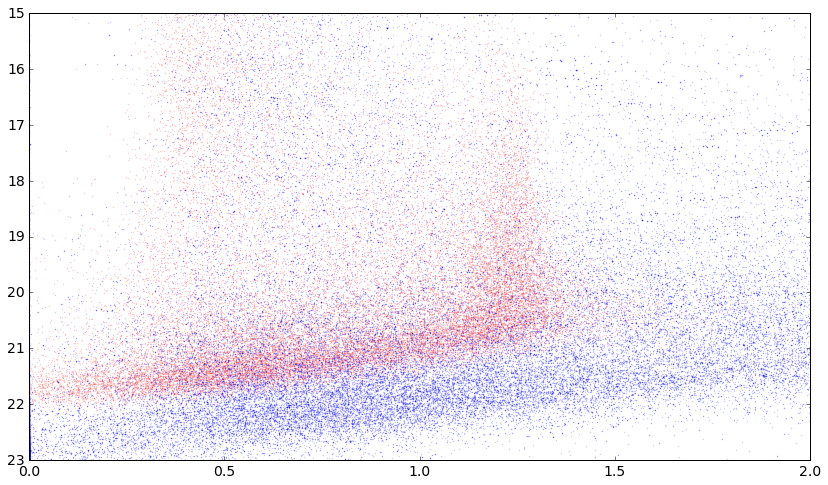

In [20]:
plt.scatter(gmi_nstack, r_nstack, alpha=.2, lw=0, s=2, c='r')
plt.scatter(gmi_stack, r_stack, alpha=.2, lw=0, s=2, c='b')

plt.xlim(0, 2)
plt.ylim(23., 15)